In [1]:
import keras
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
import keras.backend as K

from skimage.io import imread, imsave

import numpy as np

#from CustomNetworks import alexnet

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def preprocess_image(x):
    # convert to float
    x = x.astype("float32")
    # zero-center by mean pixel
    x[:, :, 0] -= 123.68
    x[:, :, 1] -= 116.779
    x[:, :, 2] -= 103.939
    # 'RGB' -> 'BGR'
    x = x[:, :, ::-1]
    return x[..., 0:3]

In [3]:
def deprocess_image(x):
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [4]:
model = VGG16()

Instructions for updating:
Colocations handled automatically by placer.


We want to first attempt to put in an input image and then get its activations. To do this we will create a new model whose job it is to get the activations and then invert the image back to the original.

In [5]:
from keras.models import Model

In [6]:
#help(keras.layers.Conv2DTranspose)

In [7]:
import tensorflow as tf

In [8]:
from keras.layers import Lambda, Reshape

In [ ]:
lrelu = lambda x: tf.keras.activations.relu(x, alpha=0.1)

In [126]:

m_input = model.get_input_at(0)
bottom  = model.get_layer("fc1").output

dense1 = keras.layers.Dense(25088, activation="relu")(bottom)
reshaped = Reshape((7, 7, 512))(dense1)

up1 = keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding="same", activation=lrelu)(reshaped)
conv1 = keras.layers.Conv2D(512, (3, 3), padding="same", activation=lrelu)(up1)
up2 = keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding="same", activation=lrelu)(conv1)
conv2 = keras.layers.Conv2D(256, (3, 3), padding="same", activation=lrelu)(up2)
up3 = keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same", activation=lrelu)(conv2)
conv3 = keras.layers.Conv2D(128, (3, 3), padding="same", activation=lrelu)(up3)

up4 = keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same", activation=lrelu)(conv3)
conv4 = keras.layers.Conv2D(64, (3, 3), padding="same", activation=lrelu)(up4)

up5 = keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same", activation=lrelu)(conv4)
conv5 = keras.layers.Conv2D(64, (3, 3), padding="same", activation=lrelu)(up5)

m_output = keras.layers.Conv2D(3, (3, 3), padding="same", activation="linear")(conv5)
#m_output = keras.layers.Lambda(lambda x : K.clip(x, -127, 127), name="Clip")(m_output)

inverse = Model(inputs=[m_input], outputs=[m_output])

inverse.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [127]:
for i, layer in enumerate(inverse.layers):
    if i <= 20:
        layer.trainable = False
    else:
        layer.trainable = True
        
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False
19 flatten False
20 fc1 False
21 dense_10 True
22 reshape_10 True
23 conv2d_transpose_46 True
24 conv2d_55 True
25 conv2d_transpose_47 True
26 conv2d_56 True
27 conv2d_transpose_48 True
28 conv2d_57 True
29 conv2d_transpose_49 True
30 conv2d_58 True
31 conv2d_transpose_50 True
32 conv2d_59 True
33 conv2d_60 True


In [128]:
def clipped_mse(y_true, y_pred):
    return K.mean(K.square(K.clip(y_pred, -127, 127) - y_true), axis=-1)

In [129]:
inverse.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss=clipped_mse)

Prepare the data to train on

In [130]:
import os

In [131]:
cat_path = "/home/simon/Desktop/Cat_Dog/training_set/cats"
dog_path = "/home/simon/Desktop/Cat_Dog/training_set/dogs"

files = [ os.path.join(cat_path, file) for file in os.listdir(cat_path)]
files.extend([ os.path.join(dog_path, file) for file in os.listdir(dog_path)])

# Clearn files
files = [ file for file in files if ".jpg" in file]

In [133]:
from skimage.transform import resize

In [134]:
class Generator(object):
    
    def __init__(self, files, batch_size = 6):
        self.files = files
        self.batch_size = batch_size
        self.i = 0
        self.order = np.arange(len(self.files))
        np.random.shuffle(self.order)
        
    def __next__(self):
        batch = []
        
        for step in range(self.batch_size):
            # Check for wrapping
            if self.i >= len(self.files):
                # Start again
                self.i = 0
                # Reshuffle
                np.random.shuffle(self.order)
                         
            x = preprocess_image(imread(self.files[self.order[self.i]]))
            
            # resize
            x = resize(x, (224, 224))
            
            batch.append(x)
            
            self.i += 1
        
        
        return np.stack(batch), np.stack(batch)
        

In [135]:
train_gen = Generator(files, batch_size=32)

In [136]:
X, y = next(train_gen)

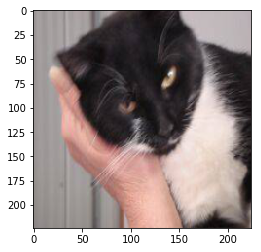

In [137]:
plt.imshow(deprocess_image(X[0].copy()))

In [138]:
#image = preprocess_image(imread("/home/simon/Desktop/eagle.png"))[np.newaxis, ::]
#image = imread("/home/simon/Desktop/eagle.png")[np.newaxis, :, :, 0:3] / 255. 
#image = imread("/home/simon/Desktop/chimp.jpg")[np.newaxis, :, :, 0:3] / 255.

In [139]:
#help(inverse.fit_generator)

In [154]:
history = inverse.fit_generator(train_gen, epochs=500, verbose=True, steps_per_epoch=100)

Epoch 1/500


/home/simon/anaconda3/envs/DL/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/simon/anaconda3/envs/DL/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


100/100 [==============================] - 54s 541ms/step - loss: 370.0651
Epoch 2/500
100/100 [==============================] - 54s 535ms/step - loss: 373.6279
Epoch 3/500
100/100 [==============================] - 54s 544ms/step - loss: 369.2066
Epoch 4/500
100/100 [==============================] - 54s 536ms/step - loss: 366.6942
Epoch 5/500
100/100 [==============================] - 54s 540ms/step - loss: 375.3975
Epoch 6/500
100/100 [==============================] - 54s 539ms/step - loss: 367.7406
Epoch 7/500
100/100 [==============================] - 54s 536ms/step - loss: 369.3680
Epoch 8/500
100/100 [==============================] - 54s 542ms/step - loss: 368.8461
Epoch 9/500
100/100 [==============================] - 54s 539ms/step - loss: 366.3956
Epoch 10/500
100/100 [==============================] - 54s 539ms/step - loss: 370.2163
Epoch 11/500
100/100 [==============================] - 54s 540ms/step - loss: 363.4696
Epoch 12/500
100/100 [==============================]

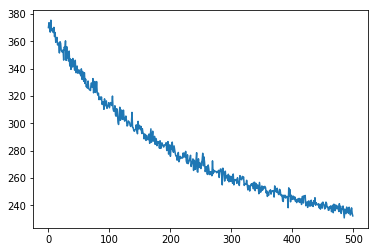

In [158]:
plt.plot(range(len(history.history["loss"])), history.history["loss"])
plt.show()

In [ ]:
inverse.save_weights("./inverse_weights_loss_232.h5")

In [167]:
X, y = next(train_gen)

In [168]:
y[0].min()

-118.65652294548191

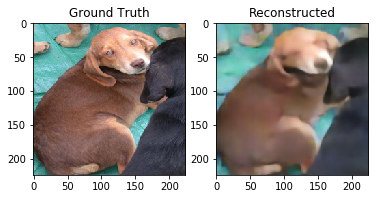

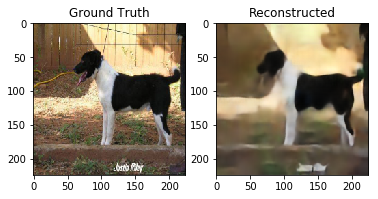

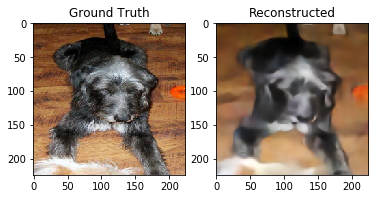

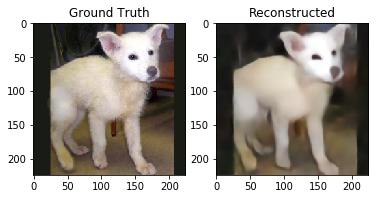

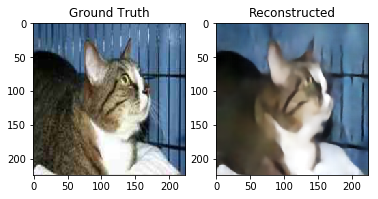

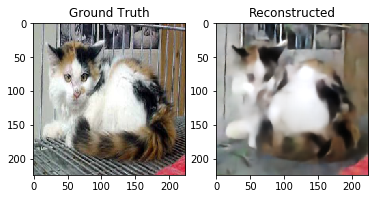

In [169]:
X, _ = next(train_gen)

for i in range(6):
    
    pred = inverse.predict(X[i][np.newaxis, ::])
    fig, axes = plt.subplots(1, 2)
    axes[0].set_title("Ground Truth")
    axes[0].imshow(deprocess_image(X[i]))
    
    axes[1].set_title("Reconstructed")
    axes[1].imshow(deprocess_image(pred[0]))

    plt.show()

In [119]:
pred[0].max()

250.68

## Validation

In [170]:
cat_test_path = "/home/simon/Desktop/Cat_Dog/test_set/cats"
dog_test_path = "/home/simon/Desktop/Cat_Dog/test_set/dogs"

test_files = [ os.path.join(cat_test_path, file) for file in os.listdir(cat_test_path)]
test_files.extend([ os.path.join(dog_test_path, file) for file in os.listdir(dog_test_path)])

# Clearn files
test_files = [ file for file in test_files if ".jpg" in file]

In [171]:
test_gen = Generator(test_files, batch_size=32)

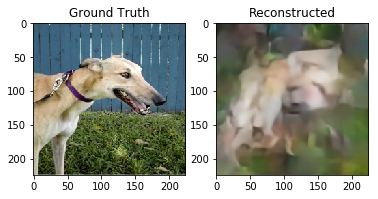

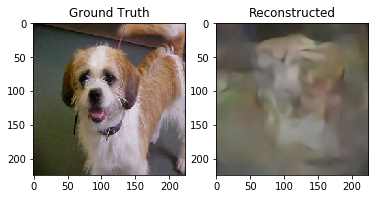

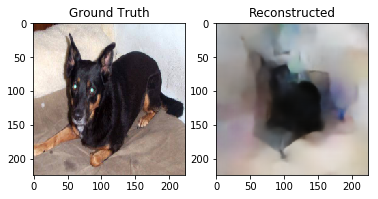

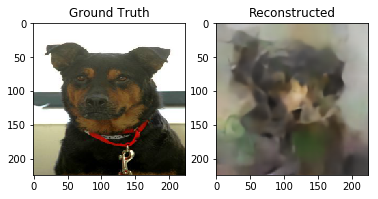

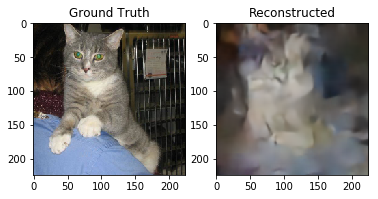

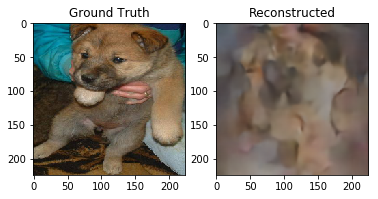

In [172]:
X, _ = next(test_gen)

for i in range(6):
    
    pred = inverse.predict(X[i][np.newaxis, ::])
    fig, axes = plt.subplots(1, 2)
    axes[0].set_title("Ground Truth")
    axes[0].imshow(deprocess_image(X[i]))
    
    axes[1].set_title("Reconstructed")
    axes[1].imshow(deprocess_image(pred[0]))

    plt.show()

## Optimisation

In [388]:
# Create generator
code_tensor = K.variable(np.random.random((1, 4096)))
x = inverse.get_layer("dense_10")(code_tensor)
x = inverse.get_layer("reshape_10")(x)
x = inverse.get_layer("conv2d_transpose_46")(x)
x = inverse.get_layer("conv2d_55")(x)
x = inverse.get_layer("conv2d_transpose_47")(x)
x = inverse.get_layer("conv2d_56")(x)
x = inverse.get_layer("conv2d_transpose_48")(x)
x = inverse.get_layer("conv2d_57")(x)
x = inverse.get_layer("conv2d_transpose_49")(x)
x = inverse.get_layer("conv2d_58")(x)
x = inverse.get_layer("conv2d_transpose_50")(x)
x = inverse.get_layer("conv2d_59")(x)
# Get generated image
gen_img = inverse.get_layer("conv2d_60")(x)
# Feed into original classifier
gen_out = model(gen_img)

In [389]:
#loss = K.variable(0.0)

#loss = K.mean(gen_out.op.inputs[0][:, 207]) # Goldren Retriever
#loss = K.mean(gen_out.op.inputs[0][:, 951]) # lemon
#loss = K.mean(gen_out.op.inputs[0][:, 889]) # violin
#loss = K.mean(gen_out.op.inputs[0][:, 983]) # Scuba diver 
#loss = K.mean(gen_out.op.inputs[0][:, 949]) # Strawberry
#loss = K.mean(gen_out.op.inputs[0][:, 920]) # traffic light
#loss = K.mean(gen_out.op.inputs[0][:, 779]) # school bus
#loss = K.mean(gen_out.op.inputs[0][:, 1]) # gold fish
#loss = K.mean(gen_out.op.inputs[0][:, 100]) # black swan
#loss = K.mean(gen_out.op.inputs[0][:, 232]) # border collie
#loss = K.mean(gen_out.op.inputs[0][:, 386]) # African Elephant
loss = K.mean(gen_out.op.inputs[0][:, 130]) # flamingo
loss *= -1

Step 0 Current loss value: -0.7247832


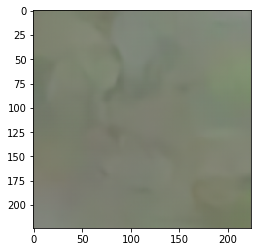

Step 100 Current loss value: -19.97171


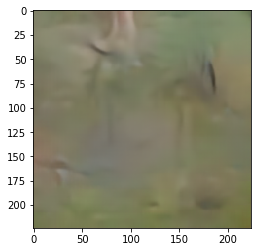

Step 200 Current loss value: -30.117777


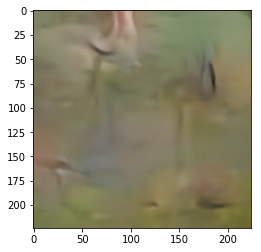

Step 300 Current loss value: -35.405983


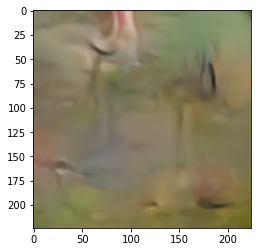

Step 400 Current loss value: -39.370995


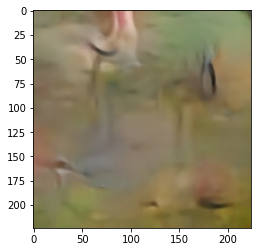

Step 500 Current loss value: -42.741886


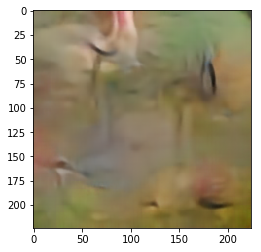

Step 600 Current loss value: -46.369427


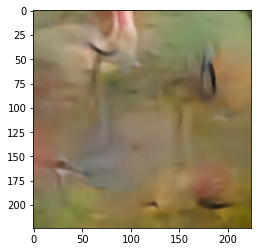

Step 700 Current loss value: -49.560684


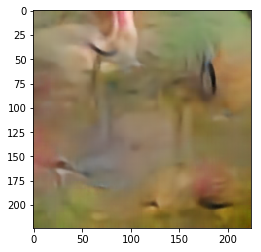

Step 800 Current loss value: -52.329258


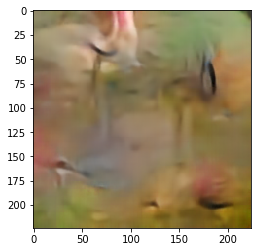

Step 900 Current loss value: -55.056507


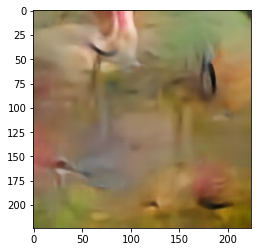

Step 1000 Current loss value: -57.64803


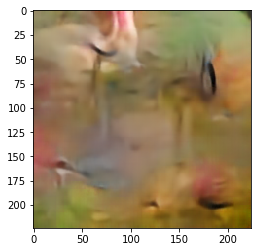

Step 1100 Current loss value: -60.42803


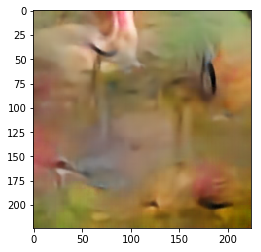

Step 1200 Current loss value: -62.542095


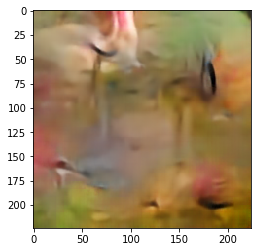

Step 1300 Current loss value: -64.75299


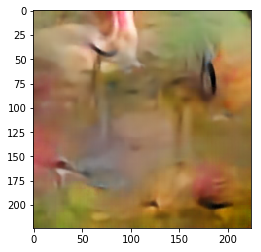

Step 1400 Current loss value: -66.99684


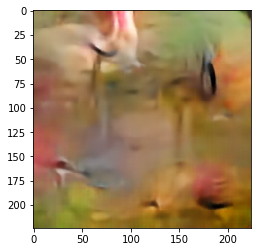

Step 1500 Current loss value: -69.08519


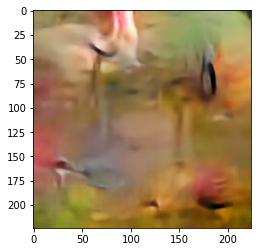

Step 1600 Current loss value: -71.16729


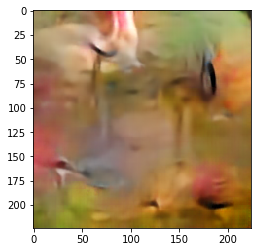

Step 1700 Current loss value: -72.92829


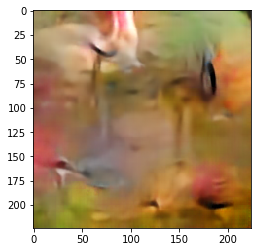

Step 1800 Current loss value: -74.96111


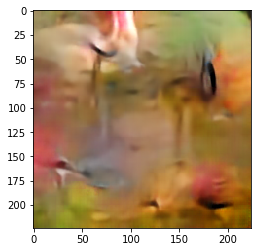

Step 1900 Current loss value: -76.926285


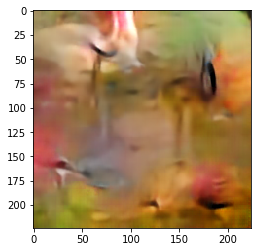

In [390]:
# Create optimizer
optimiser = tf.train.AdamOptimizer(learning_rate=0.05).minimize(loss, var_list=[code_tensor])

# Using the current Keras session
sess = K.get_session()

# Optimise the input
for i in range(2000):
    

    # Update compute loss, get gradients & update image
    loss_value, _, code, raw_img = sess.run([loss, optimiser, code_tensor, gen_img])
    
    if i % 100 == 0:
        print("Step", i, 'Current loss value:', loss_value)
        # Show current generated image
        plt.imshow(deprocess_image(raw_img[0]))
        plt.show()

In [391]:
final_img = K.eval(gen_img)
imsave("./flamingo_generated.png", deprocess_image(final_img[0]))